***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [5]:
df=pd.read_csv('URL.csv')

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (46771, 4195)


In [6]:
df['url_number_vowels'] = df['domain'].str.lower().str.count(r'[aeiou]')
df['url_number_consonants'] = df['domain'].str.count(r'[bcdfghjklmnpqrstvwxzy]', flags=re.I)
df['url_number_digits'] = df['domain'].str.count(r'\d')
df['url_number_special_chars']=df['url_length']-df[['url_number_vowels','url_number_consonants','url_number_digits']].sum(axis=1)

In [7]:
df['url_port']=df['url_port'].apply(lambda x: 0 if x==0 else 1 )
df['url_number_vowels/url_length'] = df['url_number_vowels']/df['url_length']
df['url_number_consonants/url_length'] = df['url_number_consonants']/df['url_length']
df['url_number_digits/url_length'] = df['url_number_digits']/df['url_length']
df['url_number_special_chars/url_length']=df['url_number_special_chars']/df['url_length']

In [8]:
characters='abcdefghijklmnopqrstuvwxyz0123456789'
for char in characters:
    field=char+"_average"
    df[field]=df['domain'].apply(lambda x: str.count(x, char))
    df[field]=df[field]/df['url_length']

In [9]:
df.set_index(['domain'],inplace=True,drop=True)

In [11]:
df[['a_average',
 'b_average',
 'c_average',
 'd_average',
 'e_average',
 'f_average',
 'g_average',
 'h_average',
 'i_average',
 'j_average',
 'k_average',
 'l_average',
 'm_average',
 'n_average',
 'o_average',
 'p_average',
 'q_average',
 'r_average',
 's_average',
 't_average',
 'u_average',
 'v_average',
 'w_average',
 'x_average',
 'y_average',
 'z_average',
 '0_average',
 '1_average',
 '2_average',
 '3_average',
 '4_average',
 '5_average',
 '6_average',
 '7_average',
 '8_average',
 '9_average']].head(10)

,a_average,b_average,c_average,d_average,e_average,f_average,g_average,h_average,i_average,j_average,k_average,l_average,m_average,n_average,o_average,p_average,q_average,r_average,s_average,t_average,u_average,v_average,w_average,x_average,y_average,z_average,0_average,1_average,2_average,3_average,4_average,5_average,6_average,7_average,8_average,9_average
domain,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tjk.org,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.0,0.142857,0.000000,0.142857,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0
magenta-musik-360.de,0.100000,0.000000,0.000000,0.050000,0.100000,0.000000,0.050000,0.000000,0.050000,0.000000,0.050000,0.000000,0.100000,0.050000,0.000000,0.000000,0.0,0.000000,0.050000,0.050000,0.050000,0.0,0.0,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.05,0.0,0.0,0.05,0.000000,0.000000,0.0
hitgelsin.com,0.000000,0.000000,0.076923,0.000000,0.076923,0.000000,0.076923,0.076923,0.153846,0.000000,0.000000,0.076923,0.076923,0.076923,0.076923,0.000000,0.0,0.000000,0.076923,0.076923,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0
80.82.77.17/bins-arm7,0.047619,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.000000,0.0,0.047619,0.047619,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.047619,0.047619,0.047619,0.00,0.0,0.0,0.00,0.190476,0.095238,0.0
nu.edu.bd,0.000000,0.111111,0.000000,0.222222,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.222222,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0
allocine.fr,0.090909,0.000000,0.090909,0.000000,0.090909,0.090909,0.000000,0.000000,0.090909,0.000000,0.000000,0.181818,0.000000,0.090909,0.090909,0.000000,0.0,0.090909,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0
vsetop.org,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.100000,0.0,0.100000,0.100000,0.100000,0.000000,0.1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0
ipko.pl,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.142857,0.142857,0.000000,0.000000,0.142857,0.285714,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0
0594zs.com,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.100000,0.000000,0.0,0.000000,0.100000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.100000,0.100000,0.000000,0.000000,0.00,0.1,0.1,0.00,0.000000,0.000000,0.1


In [15]:
fin_col=['url_char_%',
 'url_char_&',
 'url_char_+',
 'url_char_-',
 'url_char_.',
 'url_char_/',
 'url_char_:',
 'url_char_=',
 'url_char_?',
 'url_char__',
 'url_port',
 'url_number_vowels/url_length',
 'url_number_consonants/url_length',
 'url_number_digits/url_length',
 'url_number_special_chars/url_length',
 'url_length',
 'url_tlds',
 'url_extensions',
 'url_number_digits',
 'url_number_consonants',
 'url_number_vowels',
 'url_number_special_chars',
 'a_average',
 'b_average',
 'c_average',
 'd_average',
 'e_average',
 'f_average',
 'g_average',
 'h_average',
 'i_average',
 'j_average',
 'k_average',
 'l_average',
 'm_average',
 'n_average',
 'o_average',
 'p_average',
 'q_average',
 'r_average',
 's_average',
 't_average',
 'u_average',
 'v_average',
 'w_average',
 'x_average',
 'y_average',
 'z_average',
 '0_average',
 '1_average',
 '2_average',
 '3_average',
 '4_average',
 '5_average',
 '6_average',
 '7_average',
 '8_average',
 '9_average',
 'Target']

In [16]:
df_sel=df[fin_col]

In [17]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [18]:
train=df_sel.iloc[:37417,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[37417:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [19]:
columns=fin_col

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [20]:
columns.remove('Target')

In [21]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [22]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.969880001069
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31752   140    31892
True         987  4538     5525
__all__    32739  4678    37417

Accuracy of the model for test data is: 0.961513790892
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7924    61     7985
True         299  1070     1369
__all__     8223  1131     9354



Logistic Regression
Accuracy of the model for training data is: 0.952107330892
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31410   482    31892
True        1310  4215     5525
__all__    32720  4697    37417

Accuracy of the model for test data is: 0.95381654907
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7857   128     7985
True         304  1065     1369
__all__     8161  1193     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.995242804073
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31888     4    31892
True         174  5351     5525
__all__    32062  5355    37417

Accuracy of the model for test data is: 0.966538379303
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7911    74     7985
True         239  1130     1369
__all__     8150  1204     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.950690862442
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31300   592    31892
True        1253  4272     5525
__all__    32553  4864    37417

Accuracy of the model for test data is: 0.952426769297
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7826   159     7985
True         286  1083     1369
__all__     8112  1242     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.963198546115
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31517   375    31892
True        1002  4523     5525
__all__    32519  4898    37417

Accuracy of the model for test data is: 0.963224289074
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7877   108     7985
True         236  1133     1369
__all__     8113  1241     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.99997327418
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True           1  5524     5525
__all__    31893  5524    37417

Accuracy of the model for test data is: 0.965469317939
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7917    68     7985
True         255  1114     1369
__all__     8172  1182     9354



Bagging Classifier
Accuracy of the model for training data is: 0.994922094235
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31878    14    31892
True         176  5349     5525
__all__    32054  5363    37417

Accuracy of the model for test data is: 0.964400256575
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7894    91     7985
True         242  1127     1369
__all__     8136  1218     9354



Neural Network-1
The accuracy of the model on training data is: 0.995002271695


Predicted  False  True  __all__
Actual                         
False      31884     8    31892
True         179  5346     5525
__all__    32063  5354    37417

The accuracy of the model on test data is: 0.959161855891


Predicted  False  True  __all__
Actual                         
False       7849   136     7985
True         246  1123     1369
__all__     8095  1259     9354

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [23]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [24]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.969880,4538.0,31752.0,140.0,987.0,0.004390,0.178643
LogisticRegression,0.952107,4215.0,31410.0,482.0,1310.0,0.015114,0.237104
RandomForestClassifier,0.995243,5351.0,31888.0,4.0,174.0,0.000125,0.031493
AdaBoostClassifier,0.950691,4272.0,31300.0,592.0,1253.0,0.018563,0.226787
GradientBoostingClassifier,0.963199,4523.0,31517.0,375.0,1002.0,0.011758,0.181357
ExtraTreeClassifier,0.999973,5524.0,31892.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.994922,5349.0,31878.0,14.0,176.0,0.000439,0.031855
Neural Network-1,0.995002,5346.0,31884.0,8.0,179.0,0.000251,0.032398


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.961514,1070.0,7924.0,61.0,299.0,0.007639,0.218408,0.886977,0.839088
LogisticRegression,0.953817,1065.0,7857.0,128.0,304.0,0.016030,0.222060,0.880955,0.807330
RandomForestClassifier,0.966538,1130.0,7911.0,74.0,239.0,0.009267,0.174580,0.908076,0.861427
AdaBoostClassifier,0.952427,1083.0,7826.0,159.0,286.0,0.019912,0.208912,0.885588,0.803282
GradientBoostingClassifier,0.963224,1133.0,7877.0,108.0,236.0,0.013525,0.172389,0.907043,0.848268
ExtraTreeClassifier,0.965469,1114.0,7917.0,68.0,255.0,0.008516,0.186267,0.902608,0.856602
BaggingClassifier,0.964400,1127.0,7894.0,91.0,242.0,0.011396,0.176771,0.905916,0.852661
Neural Network-1,0.959162,1123.0,7849.0,136.0,246.0,0.017032,0.179693,0.905916,0.831921


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [25]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [26]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [27]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [28]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.97046281199
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30031   1861    31892
True          23  31869    31892
__all__    30054  33730    63784

Accuracy of the model for test data is: 0.906670942912
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7275   710     7985
True         163  1206     1369
__all__     7438  1916     9354



Logistic Regression
Accuracy of the model for training data is: 0.911310046407
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29889   2003    31892
True        3654  28238    31892
__all__    33543  30241    63784

Accuracy of the model for test data is: 0.929762668377
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7483   502     7985
True         155  1214     1369
__all__     7638  1716     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.998118650445
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31879     13    31892
True         107  31785    31892
__all__    31986  31798    63784

Accuracy of the model for test data is: 0.962582852256
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7851   134     7985
True         216  1153     1369
__all__     8067  1287     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.941207826414
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30551   1341    31892
True        2409  29483    31892
__all__    32960  30824    63784

Accuracy of the model for test data is: 0.940560188155
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7643   342     7985
True         214  1155     1369
__all__     7857  1497     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.958516242318
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30958    934    31892
True        1712  30180    31892
__all__    32670  31114    63784

Accuracy of the model for test data is: 0.950395552705
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7723   262     7985
True         202  1167     1369
__all__     7925  1429     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.999984322087
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31892      0    31892
True           1  31891    31892
__all__    31893  31891    63784

Accuracy of the model for test data is: 0.962475946119
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7861   124     7985
True         227  1142     1369
__all__     8088  1266     9354



Bagging Classifier
Accuracy of the model for training data is: 0.997413144362
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31873     19    31892
True         146  31746    31892
__all__    32019  31765    63784

Accuracy of the model for test data is: 0.961727603164
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7839   146     7985
True         212  1157     1369
__all__     8051  1303     9354



Neural Network-1
The accuracy of the model on training data is: 0.997632635144


Predicted  False   True  __all__
Actual                          
False      31800     92    31892
True          59  31833    31892
__all__    31859  31925    63784

The accuracy of the model on test data is: 0.945584776566


Predicted  False  True  __all__
Actual                         
False       7671   314     7985
True         195  1174     1369
__all__     7866  1488     9354

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [29]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [30]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.970463,31869.0,30031.0,1861.0,23.0,0.058353,0.000721
LogisticRegression,0.911310,28238.0,29889.0,2003.0,3654.0,0.062806,0.114574
RandomForestClassifier,0.998119,31785.0,31879.0,13.0,107.0,0.000408,0.003355
AdaBoostClassifier,0.941208,29483.0,30551.0,1341.0,2409.0,0.042048,0.075536
GradientBoostingClassifier,0.958516,30180.0,30958.0,934.0,1712.0,0.029286,0.053681
ExtraTreeClassifier,0.999984,31891.0,31892.0,0.0,1.0,0.000000,0.000031
BaggingClassifier,0.997413,31746.0,31873.0,19.0,146.0,0.000596,0.004578
Neural Network-1,0.997633,31833.0,31800.0,92.0,59.0,0.002885,0.001850


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.906671,1206.0,7275.0,710.0,163.0,0.088917,0.119065,0.896009,0.693663
LogisticRegression,0.929763,1214.0,7483.0,502.0,155.0,0.062868,0.113221,0.911955,0.752438
RandomForestClassifier,0.962583,1153.0,7851.0,134.0,216.0,0.016781,0.157779,0.912720,0.846991
AdaBoostClassifier,0.940560,1155.0,7643.0,342.0,214.0,0.042830,0.156318,0.900426,0.772061
GradientBoostingClassifier,0.950396,1167.0,7723.0,262.0,202.0,0.032812,0.147553,0.909818,0.805275
ExtraTreeClassifier,0.962476,1142.0,7861.0,124.0,227.0,0.015529,0.165814,0.909328,0.845870
BaggingClassifier,0.961728,1157.0,7839.0,146.0,212.0,0.018284,0.154858,0.913429,0.844060
Neural Network-1,0.945585,1174.0,7671.0,314.0,195.0,0.039324,0.142440,0.913429,0.790751


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [31]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [32]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (11050, 58)


In [33]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [34]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.926063348416
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5305   220     5525
True         597  4928     5525
__all__     5902  5148    11050

Accuracy of the model for test data is: 0.926127859739
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7473   512     7985
True         179  1190     1369
__all__     7652  1702     9354



Logistic Regression
Accuracy of the model for training data is: 0.908687782805
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5169   356     5525
True         653  4872     5525
__all__     5822  5228    11050

Accuracy of the model for test data is: 0.927945264058
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7462   523     7985
True         151  1218     1369
__all__     7613  1741     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.989230769231
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5514    11     5525
True         108  5417     5525
__all__     5622  5428    11050

Accuracy of the model for test data is: 0.940132563609
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7590   395     7985
True         165  1204     1369
__all__     7755  1599     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.906968325792
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5140   385     5525
True         643  4882     5525
__all__     5783  5267    11050

Accuracy of the model for test data is: 0.916506307462
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7353   632     7985
True         149  1220     1369
__all__     7502  1852     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.918823529412
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5256   269     5525
True         628  4897     5525
__all__     5884  5166    11050

Accuracy of the model for test data is: 0.93414581997
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7520   465     7985
True         151  1218     1369
__all__     7671  1683     9354



ExtraTree Classifier
Accuracy of the model for training data is: 1.0
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5525     0     5525
True           0  5525     5525
__all__     5525  5525    11050

Accuracy of the model for test data is: 0.941949967928
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7607   378     7985
True         165  1204     1369
__all__     7772  1582     9354



Bagging Classifier
Accuracy of the model for training data is: 0.989140271493
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5507    18     5525
True         102  5423     5525
__all__     5609  5441    11050

Accuracy of the model for test data is: 0.938101347017
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7565   420     7985
True         159  1210     1369
__all__     7724  1630     9354



Neural Network-1
The accuracy of the model on training data is: 0.999909502262


Predicted  False  True  __all__
Actual                         
False       5525     0     5525
True           1  5524     5525
__all__     5526  5524    11050

The accuracy of the model on test data is: 0.895766516998


Predicted  False  True  __all__
Actual                         
False       7154   831     7985
True         144  1225     1369
__all__     7298  2056     9354

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [35]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [36]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.926063,4928.0,5305.0,220.0,597.0,0.039819,0.108054
LogisticRegression,0.908688,4872.0,5169.0,356.0,653.0,0.064434,0.118190
RandomForestClassifier,0.989231,5417.0,5514.0,11.0,108.0,0.001991,0.019548
AdaBoostClassifier,0.906968,4882.0,5140.0,385.0,643.0,0.069683,0.116380
GradientBoostingClassifier,0.918824,4897.0,5256.0,269.0,628.0,0.048688,0.113665
ExtraTreeClassifier,1.000000,5525.0,5525.0,0.0,0.0,0.000000,0.000000
BaggingClassifier,0.989140,5423.0,5507.0,18.0,102.0,0.003258,0.018462
Neural Network-1,0.999910,5524.0,5525.0,0.0,1.0,0.000000,0.000181


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.926128,1190.0,7473.0,512.0,179.0,0.064120,0.130752,0.902564,0.737627
LogisticRegression,0.927945,1218.0,7462.0,523.0,151.0,0.065498,0.110299,0.912101,0.748507
RandomForestClassifier,0.940133,1204.0,7590.0,395.0,165.0,0.049468,0.120526,0.915003,0.779301
AdaBoostClassifier,0.916506,1220.0,7353.0,632.0,149.0,0.079148,0.108839,0.906007,0.720266
GradientBoostingClassifier,0.934146,1218.0,7520.0,465.0,151.0,0.058234,0.110299,0.915733,0.765096
ExtraTreeClassifier,0.941950,1204.0,7607.0,378.0,165.0,0.047339,0.120526,0.916068,0.784627
BaggingClassifier,0.938101,1210.0,7565.0,420.0,159.0,0.052599,0.116143,0.915629,0.774569
Neural Network-1,0.895767,1225.0,7154.0,831.0,144.0,0.104070,0.105186,0.915629,0.674934


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [37]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [38]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [39]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 6670 features
EntitySet scattered to workers in 5.303 seconds
Elapsed: 01:08 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [40]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [41]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [42]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [43]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [44]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [45]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [46]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [47]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(46771, 22)

In [48]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['url_number_consonants * w_average',
 'url_length * w_average',
 'url_char_/ / url_length',
 'url_char_. + z_average',
 'url_char_. + w_average',
 'url_char_. + url_number_special_chars/url_length',
 'url_char_. + url_char_?',
 'url_char_.',
 'url_char_& + url_char_.',
 'u_average + url_char_.',
 't_average + url_char_.',
 'l_average + url_char_.',
 'k_average + url_char_.',
 'i_average + url_char_.',
 'g_average + url_char_.',
 'd_average + url_char_.',
 'c_average + url_char_.',
 '5_average + url_char_.',
 '4_average + url_char_.',
 '3_average + url_char_.',
 '2_average + url_char_.',
 '1_average + url_char_.']

In [49]:
fs=fs.reindex(df_sel.index.values)

In [50]:
train=fs.iloc[:37417]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[37417:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [51]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [52]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.956303284603
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31532   360    31892
True        1275  4250     5525
__all__    32807  4610    37417

Accuracy of the model for test data is: 0.94815052384
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7851   134     7985
True         351  1018     1369
__all__     8202  1152     9354



Logistic Regression
Accuracy of the model for training data is: 0.941791164444
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31437   455    31892
True        1723  3802     5525
__all__    33160  4257    37417

Accuracy of the model for test data is: 0.943125935429
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7861   124     7985
True         408   961     1369
__all__     8269  1085     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.986049122057
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31819    73    31892
True         449  5076     5525
__all__    32268  5149    37417

Accuracy of the model for test data is: 0.951036989523
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7850   135     7985
True         323  1046     1369
__all__     8173  1181     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.94235240666
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31256   636    31892
True        1521  4004     5525
__all__    32777  4640    37417

Accuracy of the model for test data is: 0.942377592474
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7803   182     7985
True         357  1012     1369
__all__     8160  1194     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.950530507523
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31403   489    31892
True        1362  4163     5525
__all__    32765  4652    37417

Accuracy of the model for test data is: 0.947722899294
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7835   150     7985
True         339  1030     1369
__all__     8174  1180     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.989790736831
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31879    13    31892
True         369  5156     5525
__all__    32248  5169    37417

Accuracy of the model for test data is: 0.948898866795
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7852   133     7985
True         345  1024     1369
__all__     8197  1157     9354



Bagging Classifier
Accuracy of the model for training data is: 0.986049122057
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31813    79    31892
True         443  5082     5525
__all__    32256  5161    37417

Accuracy of the model for test data is: 0.947615993158
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7831   154     7985
True         336  1033     1369
__all__     8167  1187     9354



Neural Network-1
The accuracy of the model on training data is: 0.948926958336


Predicted  False  True  __all__
Actual                         
False      31436   456    31892
True        1455  4070     5525
__all__    32891  4526    37417

The accuracy of the model on test data is: 0.947722899294


Predicted  False  True  __all__
Actual                         
False       7853   132     7985
True         357  1012     1369
__all__     8210  1144     9354

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [53]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [54]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.956303,4250.0,31532.0,360.0,1275.0,0.011288,0.230769
LogisticRegression,0.941791,3802.0,31437.0,455.0,1723.0,0.014267,0.311855
RandomForestClassifier,0.986049,5076.0,31819.0,73.0,449.0,0.002289,0.081267
AdaBoostClassifier,0.942352,4004.0,31256.0,636.0,1521.0,0.019942,0.275294
GradientBoostingClassifier,0.950531,4163.0,31403.0,489.0,1362.0,0.015333,0.246516
ExtraTreeClassifier,0.989791,5156.0,31879.0,13.0,369.0,0.000408,0.066787
BaggingClassifier,0.986049,5082.0,31813.0,79.0,443.0,0.002477,0.080181
Neural Network-1,0.948927,4070.0,31436.0,456.0,1455.0,0.014298,0.263348


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.948151,1018.0,7851.0,134.0,351.0,0.016781,0.256392,0.863414,0.781779
LogisticRegression,0.943126,961.0,7861.0,124.0,408.0,0.015529,0.298028,0.843222,0.757709
RandomForestClassifier,0.951037,1046.0,7850.0,135.0,323.0,0.016907,0.235939,0.873577,0.795122
AdaBoostClassifier,0.942378,1012.0,7803.0,182.0,357.0,0.022793,0.260774,0.858216,0.758870
GradientBoostingClassifier,0.947723,1030.0,7835.0,150.0,339.0,0.018785,0.247626,0.866794,0.780969
ExtraTreeClassifier,0.948899,1024.0,7852.0,133.0,345.0,0.016656,0.252009,0.865668,0.785166
BaggingClassifier,0.947616,1033.0,7831.0,154.0,336.0,0.019286,0.245435,0.867640,0.780791
Neural Network-1,0.947723,1012.0,7853.0,132.0,357.0,0.016531,0.260774,0.867640,0.779668


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [55]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [65]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

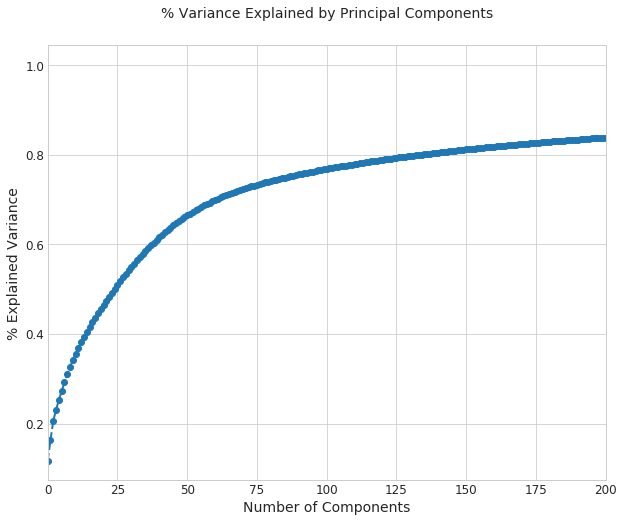

In [66]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [70]:
pca=PCA(n_components=125,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 125 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 125 components is: 0.792018705953


In [71]:
X_train=X_pca_21[:37417]
Y_train=fs.iloc[:37417]['Target'].values
X_test=X_pca_21[37417:]
Y_test=fs.iloc[37417:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [72]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,125).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.961594996927
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31854    38    31892
True        1399  4126     5525
__all__    33253  4164    37417

Accuracy of the model for test data is: 0.955954671798
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7964    21     7985
True         391   978     1369
__all__     8355   999     9354



Logistic Regression
Accuracy of the model for training data is: 0.957078333378
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31483   409    31892
True        1197  4328     5525
__all__    32680  4737    37417

Accuracy of the model for test data is: 0.959268762027
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7878   107     7985
True         274  1095     1369
__all__     8152  1202     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.994494481118
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31887     5    31892
True         201  5324     5525
__all__    32088  5329    37417

Accuracy of the model for test data is: 0.9594825743
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7893    92     7985
True         287  1082     1369
__all__     8180  1174     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.951572814496
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31307   585    31892
True        1227  4298     5525
__all__    32534  4883    37417

Accuracy of the model for test data is: 0.952533675433
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7829   156     7985
True         288  1081     1369
__all__     8117  1237     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.962289868242
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31505   387    31892
True        1024  4501     5525
__all__    32529  4888    37417

Accuracy of the model for test data is: 0.960872354073
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7866   119     7985
True         247  1122     1369
__all__     8113  1241     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.99997327418
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True           1  5524     5525
__all__    31893  5524    37417

Accuracy of the model for test data is: 0.955206328843
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7906    79     7985
True         340  1029     1369
__all__     8246  1108     9354



Bagging Classifier
Accuracy of the model for training data is: 0.993853061443
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31878    14    31892
True         216  5309     5525
__all__    32094  5323    37417

Accuracy of the model for test data is: 0.961513790892
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7896    89     7985
True         271  1098     1369
__all__     8167  1187     9354



Neural Network-1
The accuracy of the model on training data is: 0.998022289334


Predicted  False  True  __all__
Actual                         
False      31890     2    31892
True          72  5453     5525
__all__    31962  5455    37417

The accuracy of the model on test data is: 0.961620697028


Predicted  False  True  __all__
Actual                         
False       7860   125     7985
True         234  1135     1369
__all__     8094  1260     9354

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [73]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [74]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.961595,4126.0,31854.0,38.0,1399.0,0.001192,0.253213
LogisticRegression,0.957078,4328.0,31483.0,409.0,1197.0,0.012825,0.216652
RandomForestClassifier,0.994494,5324.0,31887.0,5.0,201.0,0.000157,0.036380
AdaBoostClassifier,0.951573,4298.0,31307.0,585.0,1227.0,0.018343,0.222081
GradientBoostingClassifier,0.962290,4501.0,31505.0,387.0,1024.0,0.012135,0.185339
ExtraTreeClassifier,0.999973,5524.0,31892.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.993853,5309.0,31878.0,14.0,216.0,0.000439,0.039095
Neural Network-1,0.998022,5453.0,31890.0,2.0,72.0,0.000063,0.013032


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.955955,978.0,7964.0,21.0,391.0,0.002630,0.285610,0.855880,0.814548
LogisticRegression,0.959269,1095.0,7878.0,107.0,274.0,0.013400,0.200146,0.893227,0.830669
RandomForestClassifier,0.959483,1082.0,7893.0,92.0,287.0,0.011522,0.209642,0.889418,0.830950
AdaBoostClassifier,0.952534,1081.0,7829.0,156.0,288.0,0.019537,0.210373,0.885045,0.803523
GradientBoostingClassifier,0.960872,1122.0,7866.0,119.0,247.0,0.014903,0.180424,0.902337,0.838460
ExtraTreeClassifier,0.955206,1029.0,7906.0,79.0,340.0,0.009894,0.248356,0.870875,0.811344
BaggingClassifier,0.961514,1098.0,7896.0,89.0,271.0,0.011146,0.197955,0.895450,0.839854
Neural Network-1,0.961621,1135.0,7860.0,125.0,234.0,0.015654,0.170928,0.895450,0.842143


In [75]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')